Predict the age of abalone from physical measurements

Прежде всего, импортируем необходимые библиотеки и загрузим данные.
Переведем нечисловые значения пола в числовые.
Сформируем матрицы признаков и целевой переменной.

In [2]:
from ucimlrepo import fetch_ucirepo 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest

from pandas import DataFrame
import seaborn as sns

abalone = fetch_ucirepo(id=1) 

abalone.data.original.loc[abalone.data.original['Sex'] == 'M', abalone.data.original.columns == 'Sex'] = 1
abalone.data.original.loc[abalone.data.original['Sex'] == 'F', abalone.data.original.columns == 'Sex'] = 2
abalone.data.original.loc[abalone.data.original['Sex'] == 'I', abalone.data.original.columns == 'Sex'] = 3

data_abalone = abalone.data.original
features = abalone.data.features.columns

X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values
y = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()

Посмотрим на корреляцию между признаками и целевой переменной.
Таким образом можно определить наиболее значимые признаки.

In [3]:
new_X = SelectKBest(k = 5).fit(X, y).get_feature_names_out(input_features = features)
print(new_X)

data_abalone = data_abalone[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shell_weight', 'Rings']]
X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values

['Length' 'Diameter' 'Height' 'Whole_weight' 'Shell_weight']


Теперь можно визуально оценить зависимости между выбранными признаками и целевой переменной.

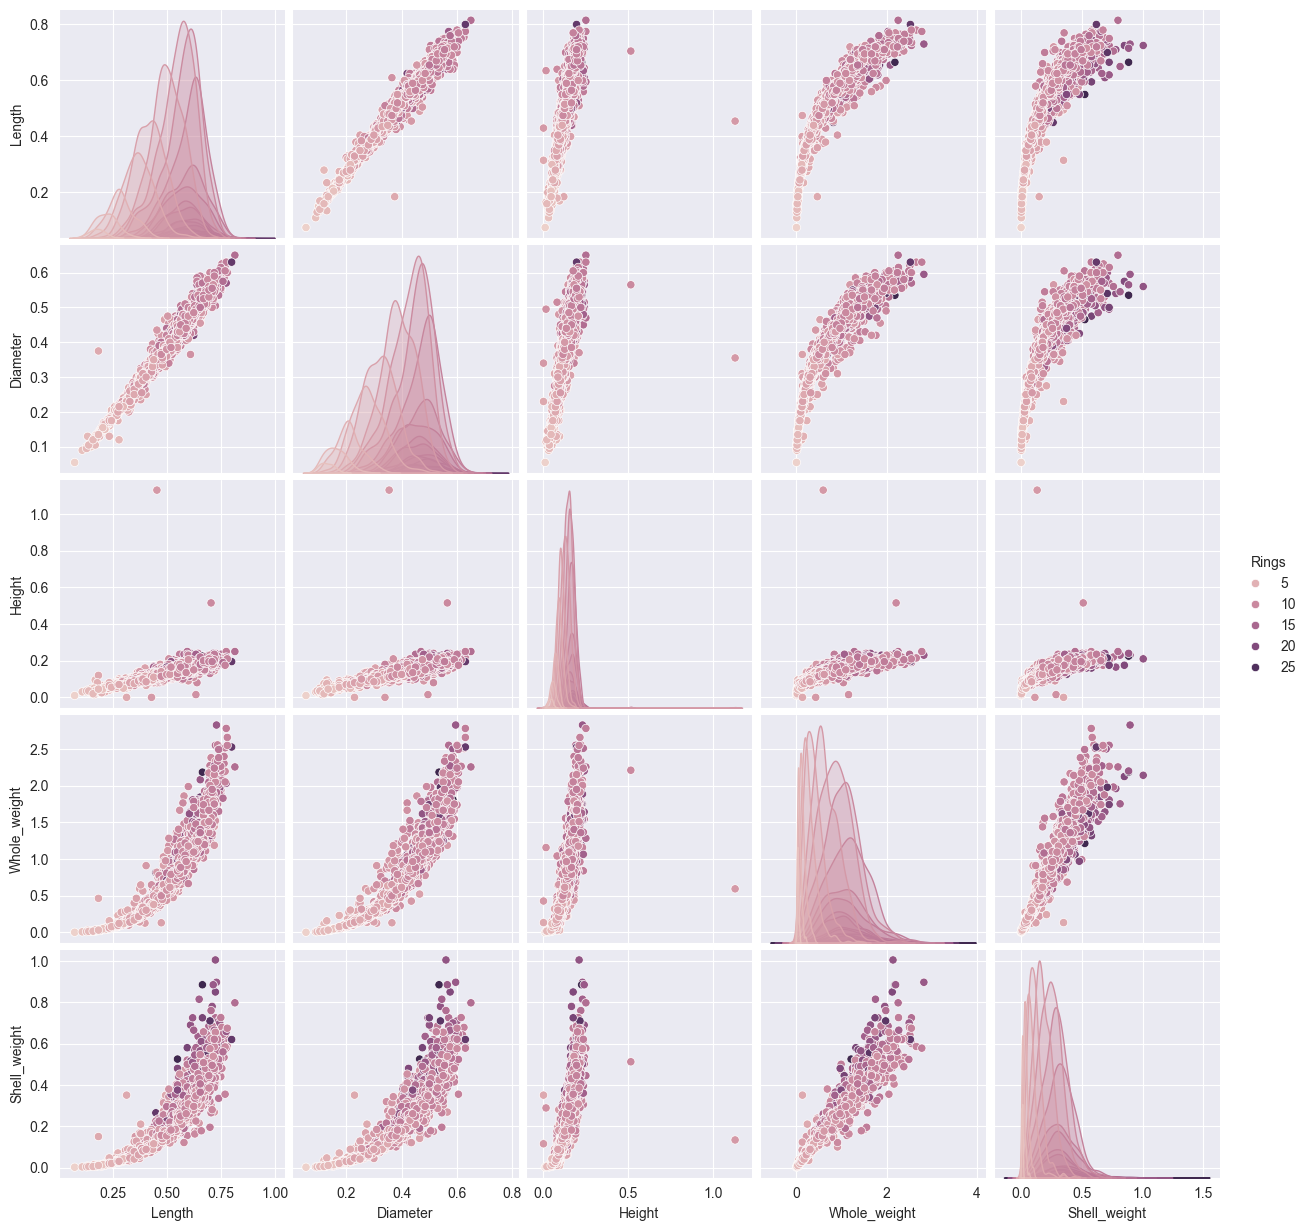

In [4]:
sns.pairplot(data=data_abalone, hue='Rings')

Можно заменить, что в датасете присутствуют выбросы, которые могут повлиять на точность моделей.
Для наглядности построим еще одну визуализацию.

<Axes: >

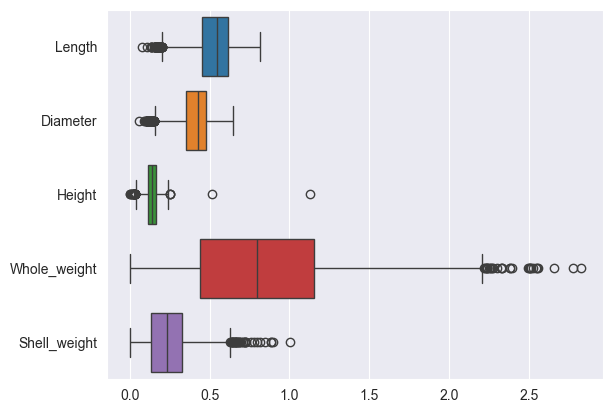

In [5]:
data_features = data_abalone[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shell_weight']]
sns.boxplot(data=data_features, orient='h')

Теперь можно удалить выбросы и посмотреть на результат.

In [6]:
print(data_abalone.shape)

Q1 = data_abalone.quantile(0.25)
Q3 = data_abalone.quantile(0.75)
IQR = Q3 - Q1

data_abalone = data_abalone[~((data_abalone < (Q1 - 1.5 * IQR)) |(data_abalone > (Q3 + 1.5 * IQR))).any(axis=1)]

print(data_abalone.shape)

(4177, 6)
(3813, 6)


Посмотрим на корреляцию между признаками и целевой переменной при удалении выбросов.

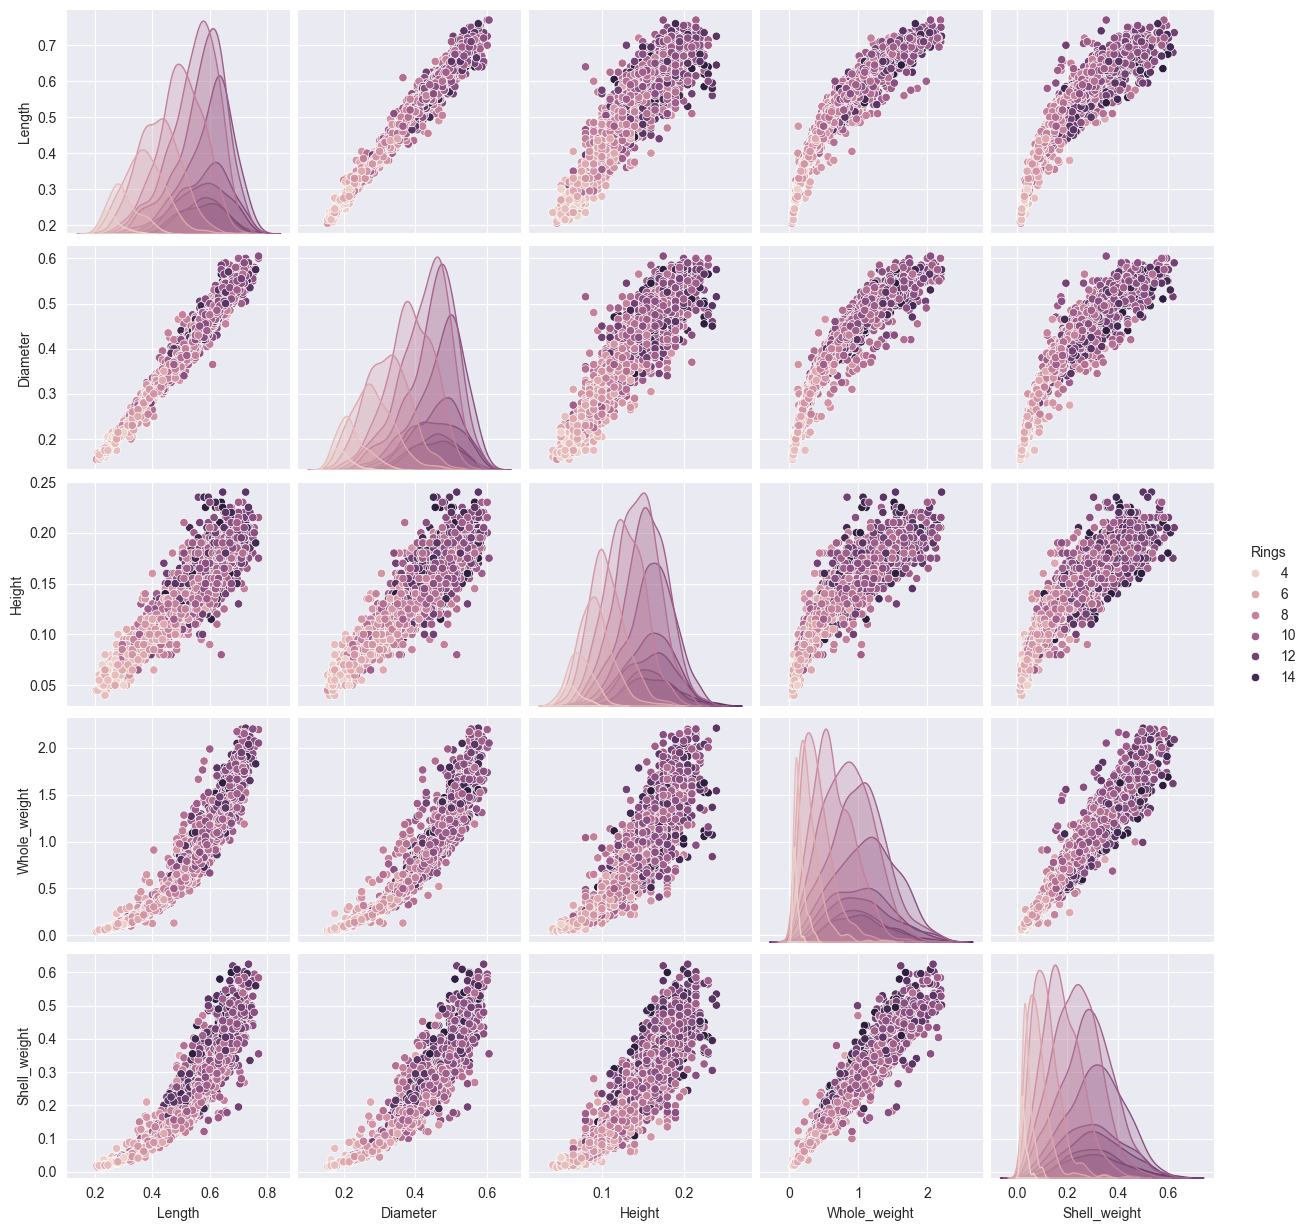

In [7]:
sns.pairplot(data=data_abalone, hue='Rings')

Теперь можно приступить к обучению моделей и оценке их точности.
Выберем модели и настроим их параметры.
Также разобьем данные на обучающую и тестовую выборки.

In [8]:
trg = data_abalone[['Rings']]
trn = data_abalone.drop(['Rings'], axis = 1)

models = [
    LinearRegression(),
    KNeighborsRegressor(n_neighbors = 7), #стоит конкретнее разобраться с выбором числа соседей
    RandomForestRegressor(n_estimators=100, max_features ='sqrt')
]

y_train, y_test, X_train, X_test = train_test_split(trg, trn, test_size = 0.4)
X_test = X_test.values
X_train = X_train.values
y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

Теперь обучим модели и посмотрим на результаты коэффициента детерминации

In [9]:
training_models = {}
names = []
scores = []

for model in models:
    names.append(str(model)[:str(model).index('(')])
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    
training_models['Model'] = names
training_models['Score'] = scores

print(training_models)
ModelsResults = DataFrame(data=training_models)
ModelsResults.set_index('Model')

{'Model': ['LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor'], 'Score': [0.4422599385219915, 0.4564727135429655, 0.45688096004049294]}


,Score
Model,
LinearRegression,0.442260
KNeighborsRegressor,0.456473
RandomForestRegressor,0.456881


Сформируем нагрлядное представление результатов (коэффициент детерминации в районе от 0 до 1)

<Axes: xlabel='Score', ylabel='Model'>

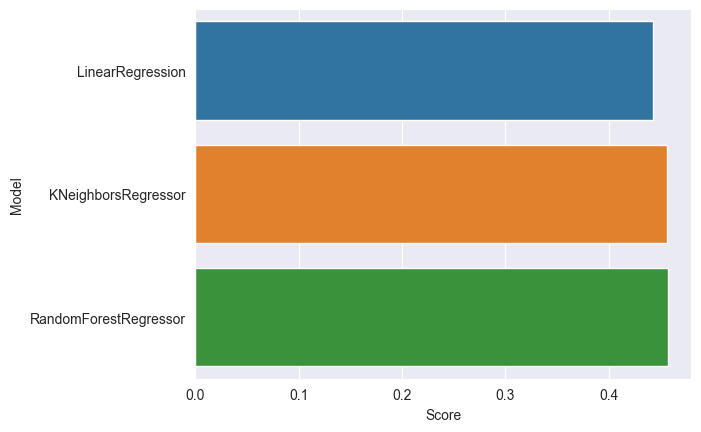

In [10]:
sns.barplot(y='Model', x='Score', data=ModelsResults, hue='Model')

ПРОМЕЖУТОЧНЫЙ ВЫВОД:
Наилучший результат показала модель случайного леса.
Однако, результаты не очень высокие, поэтому следющая гиперзадача - улучшить модели.